# BRAIN Cancer - No Feature Extraction method (NFE) on all features

In [1]:
#Import packages
import pandas as pd
import numpy as np

#import xgboost
from xgboost import XGBClassifier, plot_importance

#import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate 
from sklearn.metrics import *
from sklearn import metrics

import shap

import os

import  warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Preprocessing of data 

We run the NFE model which corresponds to XGBoost model.

## Load data and declare feature vector and target variable

In [2]:
df = pd.read_csv("/Users/justine_labory/Desktop/github/plantnet/Metabolomic_project/brain_project/data/BRAIN.ALL.FEAT.csv")
X=df.drop("Label", axis=1)
y=df["Label"]

In [3]:
X.head()

,POS_MZ560.341029343065_RT12.942705855839815,POS_MZ582.3549256690569_RT13.037459585118032,POS_MZ582.3541440245925_RT12.925013033609444,POS_MZ582.3498197201963_RT13.13071327232935,POS_MZ604.3667504095262_RT12.983984041378902,POS_MZ604.3682428195879_RT13.23584955080634,POS_MZ476.623620310892_RT13.243654193208913,POS_MZ476.62420982565936_RT13.251582010507557,POS_MZ505.9749393280406_RT13.339440116007454,POS_MZ538.3271871587282_RT12.794107598539597,...,NEG_MZ219.01303503247559_RT3.286888899620497,POS_MZ145.03214321346488_RT7.254826612477992,POS_MZ145.0323017079343_RT7.219964101151019,NEG_MZ365.13639094965134_RT8.976954356821484,POS_MZ192.0517664322376_RT2.5756727310249894,NEG_MZ268.0715771827747_RT8.83692377603365,POS_MZ175.99503531702186_RT2.8892669911266076,NEG_MZ279.0386503611643_RT3.048024073872292,POS_MZ119.04748383672113_RT2.749333539647993,NEG_MZ186.04472626383847_RT2.737924843511533
0,1.699875e+09,1.589705e+09,1.589705e+09,1.555611e+09,1.528568e+09,1.528568e+09,1.510874e+09,1.510874e+09,1.456921e+09,1.451553e+09,...,4568.223,4521.789,4521.789,4478.784,4320.359,4164.685,3714.843,3657.805,3380.98,2885.712
1,1.660000e+09,1.620000e+09,1.600000e+09,1.600000e+09,1.530000e+09,4.189201e+06,1.360000e+09,1.360000e+09,1.340000e+09,1.530000e+09,...,1633027.000,543053.100,543053.100,5923579.000,54686.820,562001.200,121669.300,3302329.000,53461.70,2603880.000
2,2.070000e+09,1.820000e+07,1.970000e+09,1.880000e+09,1.780000e+09,7.442866e+06,1.240000e+09,4.991138e+06,1.100000e+09,1.950000e+09,...,469829.300,35222.100,35222.100,521925.700,13647.850,293950.300,105111.500,238150.800,70545.81,1248023.000
3,1.610000e+09,1.210000e+07,1.720000e+09,1.500145e+06,1.430000e+09,5.055456e+06,1.130000e+09,1.130000e+09,1.180000e+09,1.740000e+09,...,1243202.000,15806.670,15806.670,5073180.000,112359.000,402177.300,72437.690,1645530.000,82386.26,2452028.000
4,4.180000e+08,4.100000e+08,3.700000e+08,6.809832e+05,4.980000e+08,4.980000e+08,7.640000e+08,7.640000e+08,7.590000e+08,3.590000e+08,...,1732952.000,63909.810,63909.810,1446918.000,59580.950,530303.800,103916.000,888951.400,39904.96,4118296.000


In [4]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Label, dtype: int64

## Run XGBoost model with cross validation

[[ 7  2]
 [ 3 10]]
0.7727272727272727
0.7735042735042735
0.8
0.8333333333333334
0.7692307692307693
0.9487179487179487


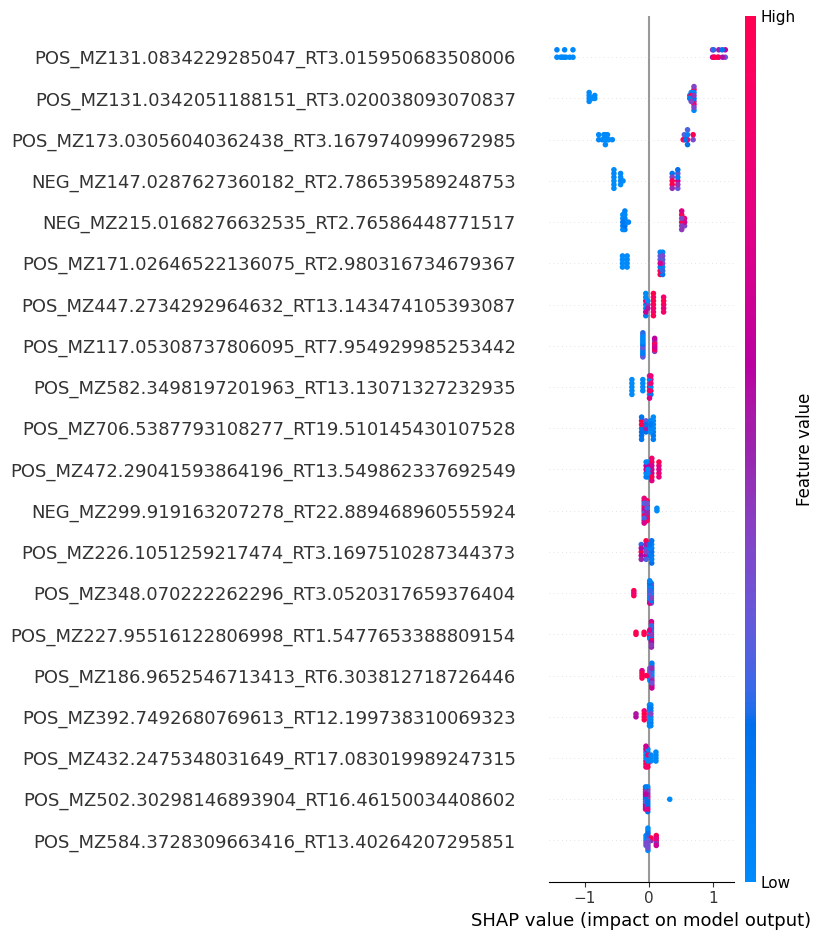

[[ 7  2]
 [ 1 12]]
0.8636363636363636
0.8504273504273505
0.888888888888889
0.8571428571428571
0.9230769230769231
0.8376068376068376


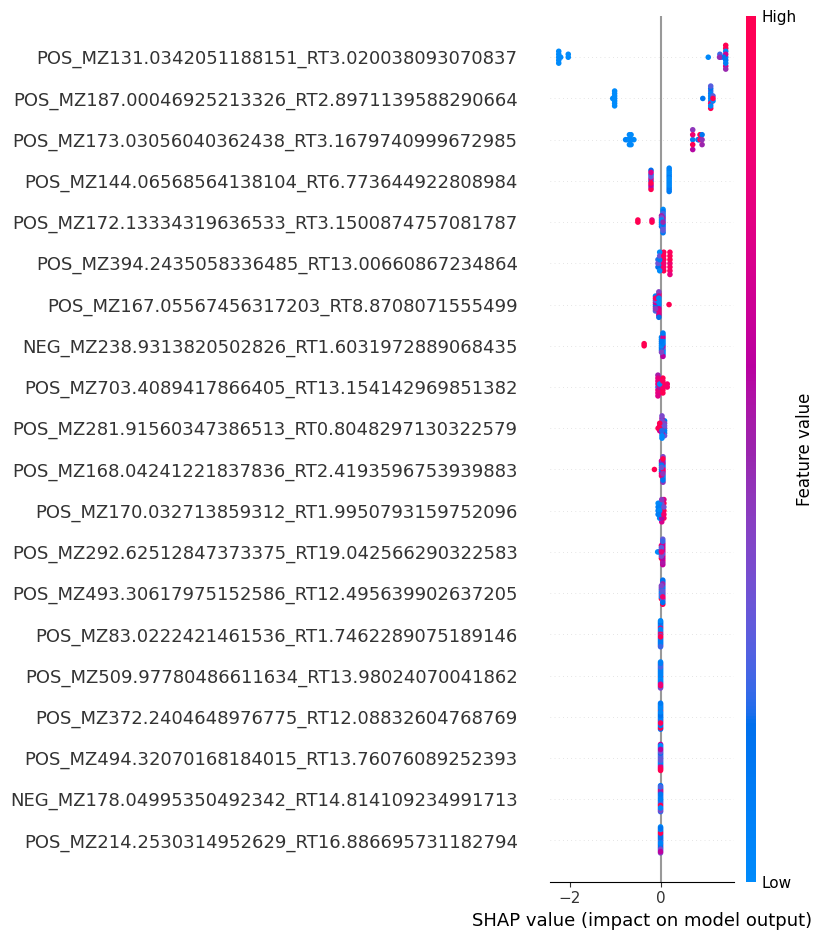

[[10  0]
 [ 0 12]]
1.0
1.0
1.0
1.0
1.0
1.0


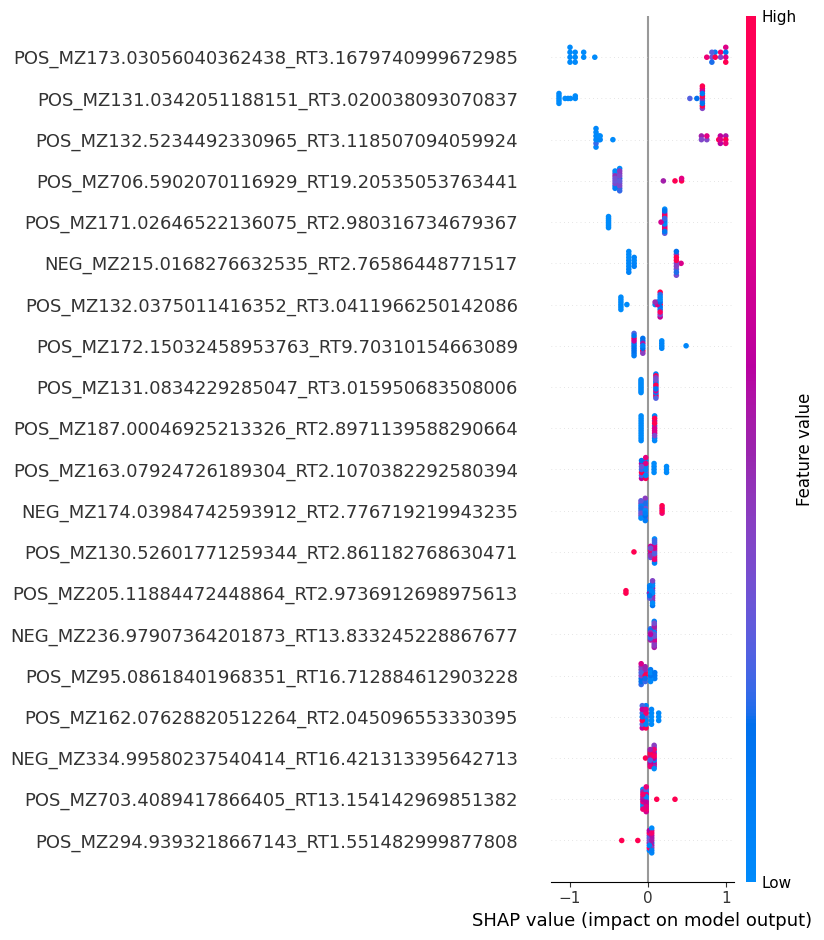

[[ 9  1]
 [ 0 12]]
0.9545454545454546
0.95
0.9600000000000001
0.9230769230769231
1.0
0.9833333333333334


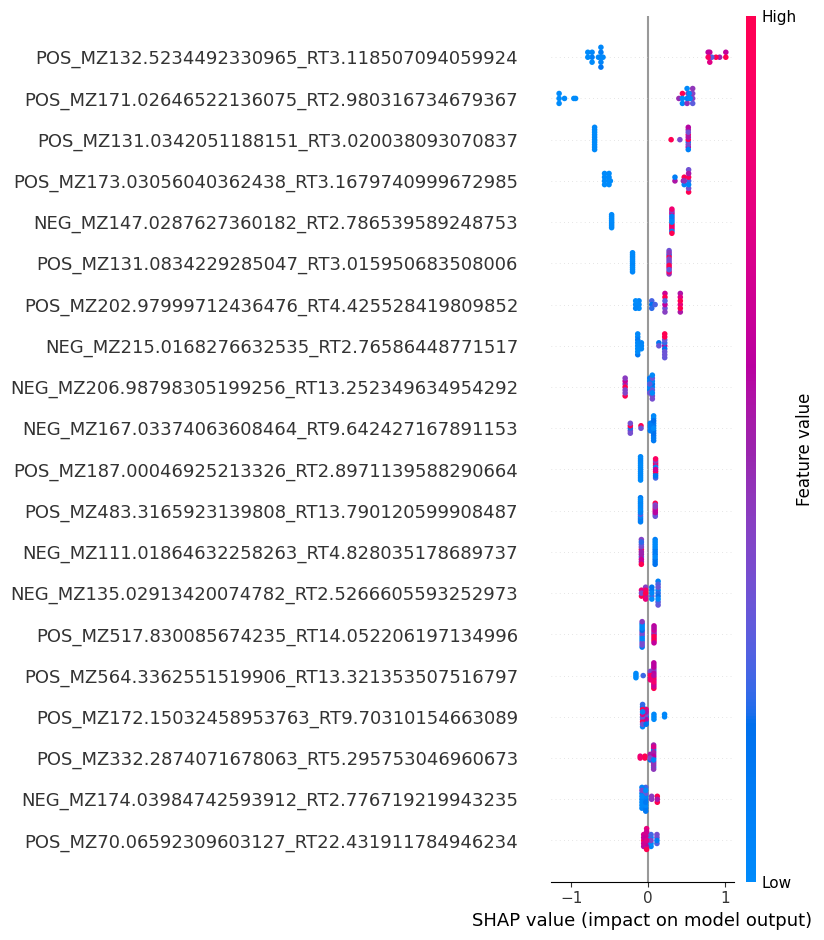

In [5]:
kfold = StratifiedKFold(n_splits=4)

lst_df = []

df_metrics = pd.DataFrame(columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1score',
                                   'roc_auc', 'specificity'],
                         index = ['fold1', 'fold2', 'fold3', 'fold4'])

cnt_fold = 1

for train_index,test_index in kfold.split(X,y):
    
    X_train=X.iloc[train_index]
    y_train=y.iloc[train_index]
    X_test=X.iloc[test_index]
    y_test=y.iloc[test_index]


    xgboost = XGBClassifier(seed=1234)

    xgboost = xgboost.fit(X_train,y_train)
    y_pred_proba = xgboost.predict_proba(X_test)[:,1]
    # # Get predicted probability
    y_pred = xgboost.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1score = metrics.f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    spe= tn / (tn + fp)
    
    # Fill in the dataframe with metrics
    df_metrics.iloc[(cnt_fold -1)] = [acc, bal_acc, f1score, precision, recall, roc_auc, spe]
    
    print(acc)
    print(bal_acc)
    print(f1score)
    print(precision)
    print(recall)
    print(roc_auc)

#     Add feature importance with SHAP

    explainer = shap.TreeExplainer(xgboost)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

    cnt_fold+=1

## Compute mean and standard deviation of metrics

In [6]:
print(f'The mean accuracy is: {np.mean(df_metrics["accuracy"])*100:.1f} (±{np.std(df_metrics["accuracy"])*100:.1f}) ')
print(f'The mean balanced accuracy is: {np.mean(df_metrics["balanced_accuracy"])*100:.1f} (±{np.std(df_metrics["balanced_accuracy"])*100:.1f}) ')
print(f'The mean precision is: {np.mean(df_metrics["precision"])*100:.1f} (±{np.std(df_metrics["precision"])*100:.1f}) ')
print(f'The mean recall is: {np.mean(df_metrics["recall"])*100:.1f} (±{np.std(df_metrics["recall"])*100:.1f}) ')
print(f'The mean F1 score is: {np.mean(df_metrics["f1score"])*100:.1f} (±{np.std(df_metrics["f1score"])*100:.1f}) ')
print(f'The mean ROC AUC is: {np.mean(df_metrics["roc_auc"])*100:.1f} (±{np.std(df_metrics["roc_auc"])*100:.1f}) ')
print(f'The mean specificity is: {np.mean(df_metrics["specificity"])*100:.1f} (±{np.std(df_metrics["specificity"])*100:.1f}) ')

The mean accuracy is: 89.8 (±8.7) 
The mean balanced accuracy is: 89.3 (±8.8) 
The mean precision is: 91.2 (±7.6) 
The mean recall is: 90.3 (±6.5) 
The mean F1 score is: 92.3 (±9.4) 
The mean ROC AUC is: 94.2 (±6.3) 
The mean specificity is: 86.4 (±9.3) 


## Compute 95% CI

In [7]:
acc_ci= np.percentile(df_metrics["accuracy"], [2.5,97.5])
bal_acc_ci= np.percentile(df_metrics["balanced_accuracy"], [2.5,97.5])
precision_ci = np.percentile(df_metrics["precision"], [2.5,97.5])
recall_ci= np.percentile(df_metrics["recall"], [2.5,97.5])
f1_ci = np.percentile(df_metrics["f1score"], [2.5,97.5])
roc_auc_ci = np.percentile(df_metrics["roc_auc"], [2.5,97.5])
specificity_ci = np.percentile(df_metrics['specificity'], [2.5,97.5])

print(f'The confidence interval for accuracy is [{acc_ci[0]*100:.1f} ; {acc_ci[1]*100:.1f}]')
print(f'The confidence interval for balanced accucary is [{bal_acc_ci[0]*100:.1f} ; {bal_acc_ci[1]*100:.1f}]')
print(f'The confidence interval for precision is [{precision_ci[0]*100:.1f} ; {precision_ci[1]*100:.1f}]')
print(f'The confidence interval for recall is [{recall_ci[0]*100:.1f} ; {recall_ci[1]*100:.1f}]')
print(f'The confidence interval for F1 score is [{f1_ci[0]*100:.1f} ; {f1_ci[1]*100:.1f}]')
print(f'The confidence interval for ROC AUC score is [{roc_auc_ci[0]*100:.1f} ; {roc_auc_ci[1]*100:.1f}]')
print(f'The confidence interval for specificity score is [{specificity_ci[0]*100:.1f} ; {specificity_ci[1]*100:.1f}]')

The confidence interval for accuracy is [78.0 ; 99.7]
The confidence interval for balanced accucary is [77.9 ; 99.6]
The confidence interval for precision is [80.7 ; 99.7]
The confidence interval for recall is [83.5 ; 99.4]
The confidence interval for F1 score is [78.1 ; 100.0]
The confidence interval for ROC AUC score is [84.6 ; 99.9]
The confidence interval for specificity score is [77.8 ; 99.2]
